# ASK BERT - ML.NET & ONNX DEMO
## Bidirectional Encoder Representations from Transformers

- Integrating an ONNX Model into ML.NET
- Models can found all over the internet, main sources: [Hugging Face](https://huggingface.co/) or Github, namely [ONNX Model Zoo](https://github.com/onnx/models/tree/main)
- Quantized BERT From [Gigabyte0x1337/BERT-ML.NET](https://github.com/Gigabyte0x1337/BERT-ML.NET)

## 0. Quantization
- Allows to perform faster binary calculations
- Smaller
- Tradeoff: accuracy

![1 Nghatk-wVo9gjHjynTd46Q.webp](<attachment:1 Nghatk-wVo9gjHjynTd46Q.webp>)

[Source](https://medium.com/@joel_34050/quantization-in-deep-learning-478417eab72b)
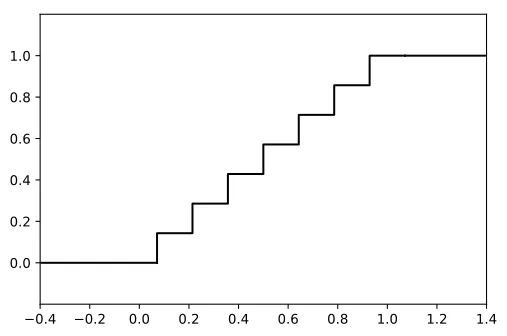

#### 1. Loading Dependencies

In [1]:
#r "nuget: BERTTokenizers"
#r "nuget: Microsoft.ML.OnnxRuntime"
#r "nuget: Microsoft.ML.OnnxRuntime.Managed"
#r "nuget: Microsoft.ML.OnnxTransformer"
#r "nuget: Microsoft.ML"
using BERTTokenizers;
using Microsoft.ML.Data;
using Microsoft.ML.OnnxRuntime;
using Microsoft.ML.OnnxRuntime.Tensors;
using System;
using System.Linq;
using System.Runtime.CompilerServices;
using Microsoft.ML;
using BERTTokenizers.Base;

Installed Packages BERTTokenizers, 1.2.0 Microsoft.ML, 2.0.1 Microsoft.ML.OnnxRuntime, 1.15.1 Microsoft.ML.OnnxRuntime.Managed, 1.15.1 Microsoft.ML.OnnxTransformer, 2.0.1

### 1.1 Hack to load ONNX Runtime within notebooks

In [2]:
// https://github.com/dotnet/interactive/issues/967#issuecomment-868738762
using System.Reflection;
using System.Runtime.InteropServices;

static class Library
{
    public static IntPtr OnnxRuntimeImportResolver(string libraryName, Assembly assembly, DllImportSearchPath? searchPath)
    {
        if (libraryName != "onnxruntime") 
            return IntPtr.Zero;

        var fullLoc = Assembly.Load("Microsoft.ML.OnnxRuntime").Location;
        var loc = fullLoc.Substring(0, fullLoc.IndexOf("microsoft.ml.onnxruntime.managed"));
        loc += @"microsoft.ml.onnxruntime/1.15.1/runtimes/";

        if (RuntimeInformation.IsOSPlatform(OSPlatform.Windows))
            loc += "win-x64";
        else if (RuntimeInformation.IsOSPlatform(OSPlatform.Linux))
            loc += "linux-x64";
        else
            loc += "osx-x64";

            loc +="/native/onnxruntime.dll";

        IntPtr libHandle = IntPtr.Zero;
        NativeLibrary.TryLoad(loc, out libHandle);

        return libHandle;
    }
}

NativeLibrary.SetDllImportResolver(Assembly.Load("Microsoft.ML.OnnxRuntime"), Library.OnnxRuntimeImportResolver);

#### 2.1 Define Classes

In [3]:
public class BertInput
{
    [VectorType(1)]
    [ColumnName("unique_ids_raw_output___9:0")]
    public long[] UniqueIds { get; set; }

    [VectorType(1, 256)]
    [ColumnName("segment_ids:0")]
    public long[] SegmentIds { get; set; }

    [VectorType(1, 256)]
    [ColumnName("input_mask:0")]
    public long[] InputMask { get; set; }

    [VectorType(1, 256)]
    [ColumnName("input_ids:0")]
    public long[] InputIds { get; set; }
}

public class BertOutput
{
    [VectorType(1, 256)]
    [ColumnName("unstack:1")]
    public float[] EndLogits { get; set; }

    [VectorType(1, 256)]
    [ColumnName("unstack:0")]
    public float[] StartLogits { get; set; }

    [VectorType(1)]
    [ColumnName("unique_ids:0")]
    public long[] UniqueIds { get; set; }
}

#### 2.12 How do you know?
- Lutz Roeder's [Netron](https://github.com/lutzroeder/netron): Model Properties

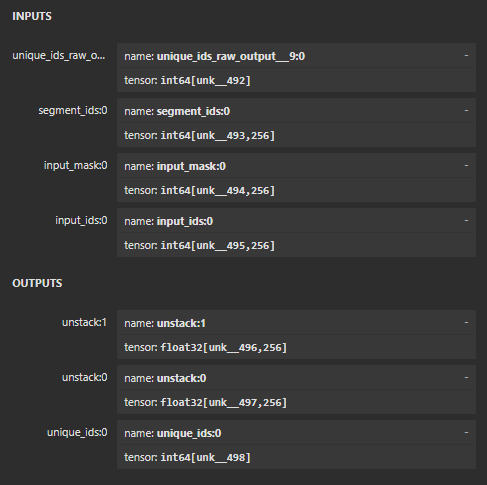

#### 3.1 "Load Data"

In [4]:
var mlNetContext = new MLContext();
IDataView dataView = mlNetContext.Data.LoadFromEnumerable(Enumerable.Empty<BertInput>());

#### 3.2 Create the pipeline with the ONNX model



In [5]:

var pipeline = mlNetContext.Transforms.ApplyOnnxModel(
    modelFile: "bertsquad-10.onnx",
    inputColumnNames: new[] { "unique_ids_raw_output___9:0", "segment_ids:0", "input_mask:0", "input_ids:0" },
    outputColumnNames: new[]{ "unstack:1", "unstack:0", "unique_ids:0" },
    gpuDeviceId: null // iGPU is not supported
    );
var bertModel = pipeline.Fit(dataView);

#### 3.3 Create the prediction engine
> **Watch out**: Not thread safe

In [6]:
var predictionEngine = mlNetContext.Model.CreatePredictionEngine<BertInput, BertOutput>(bertModel);

### Tokenization

> **Watch out**: Umlauts and other non English characters may give you some trouble

In [7]:
public class BertSquad10Tokenizer : UncasedTokenizer
{
    public BertSquad10Tokenizer() : base("Vocabularies/bertsquad-10.txt"){}
}

In [8]:
public BertInput Tokenize(string question, string context)
{
    string sentence = $"{question}[SEP]{context}";

    var tokenizer = new BertSquad10Tokenizer();
    var questionTokenCount = tokenizer.Tokenize(question).Count;

    var encoded = tokenizer.Encode(256, sentence);

    return new(){
        InputIds = encoded.Select(x => x.InputIds).ToArray(),
        InputMask = encoded.Select(x => x.AttentionMask).ToArray(),
        SegmentIds = Enumerable.Repeat<long>(0, questionTokenCount).Concat(Enumerable.Repeat<long>(1, 256 - questionTokenCount)).ToArray(),
        UniqueIds = new long[] { 0 }
    };
}

In [9]:
var output = predictionEngine.Predict(Tokenize("What city is it happening in?", ".NET Day Switzerland 2023 takes place on Tuesday, the 29.08.2023 at the Arena Cinemas at Sihlcity in Zurich."));
output

EndLogits,"[ 3.409843, -7.9832406, -7.706461, -8.075462, -8.5506115, -8.507554, -8.346799, -8.402157, -8.453956, -7.6614666, -5.220538, -7.136705, -7.604162, -4.995484, -3.8048356, -7.334656, -2.2054617, -8.576561, -6.630194, -8.466929 ... (236 more) ]"
StartLogits,"[ 2.145027, -8.027615, -8.425635, -8.725562, -8.219882, -8.193594, -8.431355, -8.543914, -8.295039, -8.125716, -7.885604, -6.3418694, -6.238595, -8.194446, -2.8782628, -5.3571796, -8.618738, -6.087705, -8.635133, -6.3024035 ... (236 more) ]"
UniqueIds,[ 0 ]


### Postprocessing

> Simplest way, in practice soft-max for more possible end / start combinations is advisable!

In [10]:
public string PostprocessResult(BertOutput output, string question, string context)
{
    var tokenizer = new BertSquad10Tokenizer();
    var questionTokenCount = tokenizer.Tokenize(question).Count;
    var tokens = tokenizer.Tokenize(context);

    var sentenceStartLogits = output.StartLogits.Skip(questionTokenCount + 1).ToArray();
    var sentenceEndLogits = output.EndLogits.Skip(questionTokenCount + 1).ToArray();

    var startIndex = Array.IndexOf(sentenceStartLogits, sentenceStartLogits.Max());
    var endIndex = Array.IndexOf(sentenceEndLogits, sentenceEndLogits.Max());

    var answerTokens = tokens.Skip(startIndex).Take(endIndex - startIndex + 1);
    return string.Join(" ", answerTokens.Select(token => tokenizer.IdToToken(token.VocabularyIndex)));

}

In [11]:
output = predictionEngine.Predict(Tokenize("What city is it happening in?", ".NET Day Switzerland 2023 takes place on Tuesday, the 29.08.2023 at the Arena Cinemas at Sihlcity in Zurich."));
PostprocessResult(output, "What city is it happening in?", ".NET Day Switzerland 2023 takes place on Tuesday, the 29.08.2023 at the Arena Cinemas at Sihlcity in Zurich.")

zurich

In [12]:
output = predictionEngine.Predict(Tokenize("What place is it happening in?", ".NET Day Switzerland 2023 takes place on Tuesday, the 29.08.2023 at the Arena Cinemas at Sihlcity in Zurich."));
PostprocessResult(output, "What place is it happening in?", ".NET Day Switzerland 2023 takes place on Tuesday, the 29.08.2023 at the Arena Cinemas at Sihlcity in Zurich.")

si ##hl ##city

In [13]:
public string StitchTogether(string input) => input.Replace(" ##", "");

In [14]:
public string AnswerQuestion(string question, string context)
{
    var output = predictionEngine.Predict(Tokenize(question, context));
    return StitchTogether(PostprocessResult(output, question, context));
}

In [15]:
AnswerQuestion(
    "What place is it happening in?", 
    ".NET Day Switzerland 2023 takes place on Tuesday, the 29.08.2023 at the Arena Cinemas at Sihlcity in Zurich.")

sihlcity

### Let's play

In [16]:
using System.IO;
public (string speaker, string bio)[] LoadSpeakerInfo(){
    return File.ReadLines(@"C:\Users\alexander.kayed\OneDrive\Dokumente\Arbeit\Noser\2023\NetDay\SessionsAndSpeakers.csv")
               .Skip(1)
               .Select(line => line.Split(";"))
               .Select(line => (speaker: line[3], bio: line[4]))
               .ToArray();
}

In [17]:
LoadSpeakerInfo().Take(2)

index value 0 (Jon Galloway, Jon is a Program Manager on the .NET team. He's been developing software professionally since the late 1990's, and over the years has written several books, popular .NET tutorials and samples, a top speaker on Microsoft Virtual Academy, and worked behind the scenes on large Microsoft ... Item1 Jon Galloway Item2 Jon is a Program Manager on the .NET team. He's been developing software professionally since the late 1990's, and over the years has written several books, popular .NET tutorials and samples, a top speaker on Microsoft Virtual Academy, and worked behind the scenes on large Microsoft keynote demonstrations. He's helped run the Herding Code podcast for 10 years, and tweets as @jongalloway. 1 (Christian Weyer, Christian Weyer is co-founder and CTO of Thinktecture AG. As a Microsoft MVP, RD and Google GDE, he has been speaking at a wide variety of software conferences and events worldwide for more than 25 years - with passion and commitment, especially for distributed application architec... Item1 Christian Weyer Item2 Christian Weyer is co-founder and CTO of Thinktecture AG. As a Microsoft MVP, RD and Google GDE, he has been speaking at a wide variety of software conferences and events worldwide for more than 25 years - with passion and commitment, especially for distributed application architectures and cross-platform solutions. A deeply technical as well as realistic assessment of technologies is one of his trademarks. e diverse organizational needs. Come in and find out!

In [18]:
LoadSpeakerInfo().Select(x => (x.speaker, AnswerQuestion("Where does she/he work currently?", x.bio)))

index value 0 (Jon Galloway, . net team) Item1 Jon Galloway Item2 . net team 1 (Christian Weyer, thinktecture ag) Item1 Christian Weyer Item2 thinktecture ag 2 (Rachel Appel, jetbrains) Item1 Rachel Appel Item2 jetbrains 3 (Filip Wojcieszyn, medical industry) Item1 Filip Wojcieszyn Item2 medical industry 4 (Laurent Bugnion, zurich) Item1 Laurent Bugnion Item2 zurich 5 (Alexander Kayed, noser engineering ag) Item1 Alexander Kayed Item2 noser engineering ag 6 (Andrei Epure, microsoft ireland , almetis france , and bitdefender romania) Item1 Andrei Epure Item2 microsoft ireland , almetis france , and bitdefender romania 7 (Miroslav Popovic, ) Item1 Miroslav Popovic Item2 8 (Dennis Dietrich, microsoft) Item1 Dennis Dietrich Item2 microsoft 9 (Dona Sarkar, microsoft) Item1 Dona Sarkar Item2 microsoft 10 (Daniel Marbach, particular software) Item1 Daniel Marbach Item2 particular software 11 (Marc Mueller, 4tecture gmbh) Item1 Marc Mueller Item2 4tecture gmbh 12 (Laila Bougria, particular software) Item1 Laila Bougria Item2 particular software 13 (Damien Bowden, github) Item1 Damien Bowden Item2 github 14 (Devlin Duldulao, norway) Item1 Devlin Duldulao Item2 norway 15 (Steven Giesel, zuehlke engineering ag) Item1 Steven Giesel Item2 zuehlke engineering ag 16 (Mark Allibone, rey technology) Item1 Mark Allibone Item2 rey technology 17 (Roland Guijt, microsoft mvp , asp . net insider and pluralsight author enjoying a constant curiosity around new techniques in software development . his focus is on all things . net and browser technologies) Item1 Roland Guijt Item2 microsoft mvp , asp . net insider and pluralsight author enjoying a constant curiosity around new techniques in software development . his focus is on all things . net and browser technologies 18 (Urs Enzler, software architect) Item1 Urs Enzler Item2 software architect 19 (Annie Talvasto, annie talvasto is an international technology speaker , cncf ambassador , azure mvp and specialist in kubernetes & cloud native ecosystem . annie hosts & produces the cloud gossip podcast and has been a co - organizer of kubernetes & cncf finland) Item1 Annie Talvasto Item2 annie talvasto is an international technology speaker , cncf ambassador , azure mvp and specialist in kubernetes & cloud native ecosystem . annie hosts & produces the cloud gossip podcast and has been a co - organizer of kubernetes & cncf finland ... (more)

### It's AI
- Safety nets always required
- Better postprocession
- Larger model (less quantized, cased, etc.)